In [1]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb

from sklearn.model_selection import train_test_split

In [2]:
IMG_WIDHT = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [3]:
def get_files_list(base_dir):
    files = []
    for sub_dir in os.listdir(base_dir):
        ls = os.listdir(os.path.join(base_dir,sub_dir))
        for f in ls:
            files.append(os.path.join(base_dir,sub_dir,f))
    return files

In [4]:
raw_dir = 'tomato/colour/'
seg_dir = 'tomato/segmented_bw/'

In [5]:
raw_files_list = get_files_list(raw_dir)
seg_files_list = get_files_list(seg_dir)

In [6]:
raw_files_list = raw_files_list[:2000]
seg_files_list = seg_files_list[:2000]

In [7]:
X = np.zeros((len(raw_files_list), IMG_HEIGHT, IMG_WIDHT, IMG_CHANNELS), dtype=np.float32)
Y = np.zeros((len(seg_files_list), IMG_HEIGHT, IMG_WIDHT, 1), dtype=np.float32)

In [8]:
X.shape

(2000, 256, 256, 3)

In [9]:
def pre_process_imgs(image_bgr):

    image_bgr = cv2.resize(image_bgr, (IMG_HEIGHT, IMG_WIDHT))
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)

    # Separate LAB channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # Normalize LAB channels to the range [0, 1]
    l_channel_norm = l_channel / 255.0
    a_channel_norm = (a_channel + 128) / 255.0  # Shift a* component to [0, 255]
    b_channel_norm = (b_channel + 128) / 255.0  # Shift b* component to [0, 255]

    # Merge normalized LAB channels back into LAB image
    image_lab_norm = cv2.merge([l_channel_norm, a_channel_norm, b_channel_norm])
    return image_lab_norm

    # return image_lab

In [10]:
for n,id_ in tqdm(enumerate(raw_files_list),total=len(raw_files_list)):
    img = cv2.imread(id_, cv2.IMREAD_COLOR)
    img = pre_process_imgs(img)
    X[n] = img

100%|██████████| 2000/2000 [00:04<00:00, 410.56it/s]


In [11]:
for n,id_ in tqdm(enumerate(seg_files_list),total=len(seg_files_list)):
    img = cv2.imread(id_, cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(cv2.resize(img, (IMG_HEIGHT, IMG_WIDHT)), axis=-1)
    img = img/255.0
    Y[n] = img

100%|██████████| 2000/2000 [00:01<00:00, 1192.23it/s]


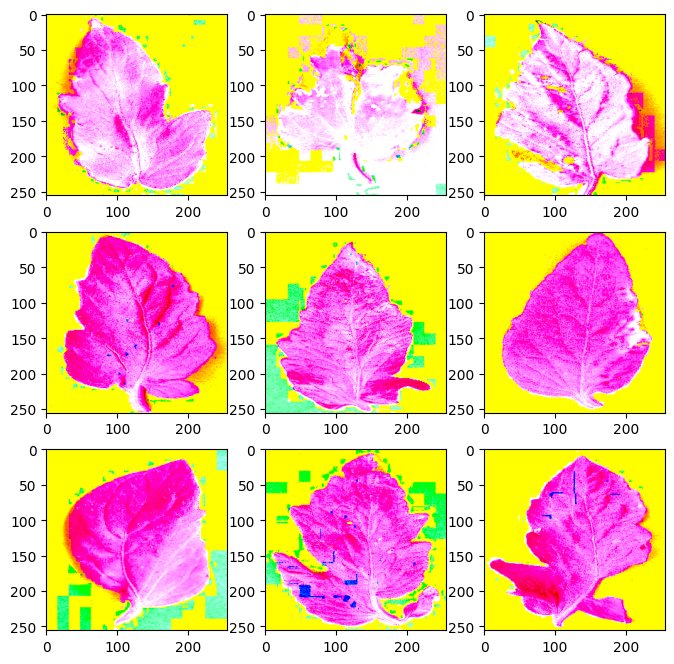

In [12]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, 3*3 +1):
    img = X[i]
    l_channel, a_channel, b_channel = cv2.split(img)

    # Normalize LAB channels to the range [0, 1]
    l_channel_norm = l_channel * 255.0
    a_channel_norm = a_channel * 255 - 128 # Shift a* component to [0, 255]
    b_channel_norm = b_channel * 255 - 128  # Shift b* component to [0, 255]
    img = cv2.merge([l_channel_norm, a_channel_norm, b_channel_norm])
    fig.add_subplot(3, 3, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))
    # plt.imshow(img)

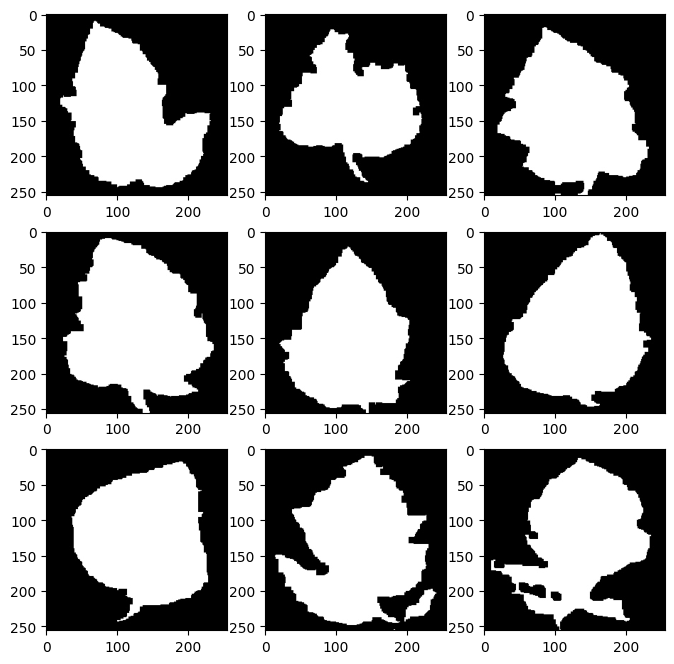

In [13]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, 3*3 +1):
    img = Y[i]
    fig.add_subplot(3, 3, i)
    plt.imshow(img, cmap='gray')

In [14]:
def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.0)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true,y_pred)

In [29]:
model = tf.keras.models.load_model('tomato_lab_1.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef})

In [31]:
model = tf.keras.models.load_model('tomato_lab_resu2.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef})

In [24]:
from tensorflow.keras import backend as K
model = tf.keras.models.load_model('tomato_lab_aresu1.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef})

In [15]:
# res = model.predict(X)

In [32]:
model.evaluate(X,Y)

100/100 [==============================] - 78s 746ms/step - loss: 0.0254 - dice_coef: 0.9746


[0.025380810722708702, 0.9745666980743408]

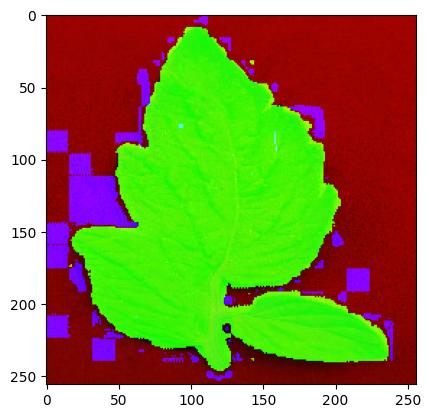

In [17]:
plt.imshow(X[0])

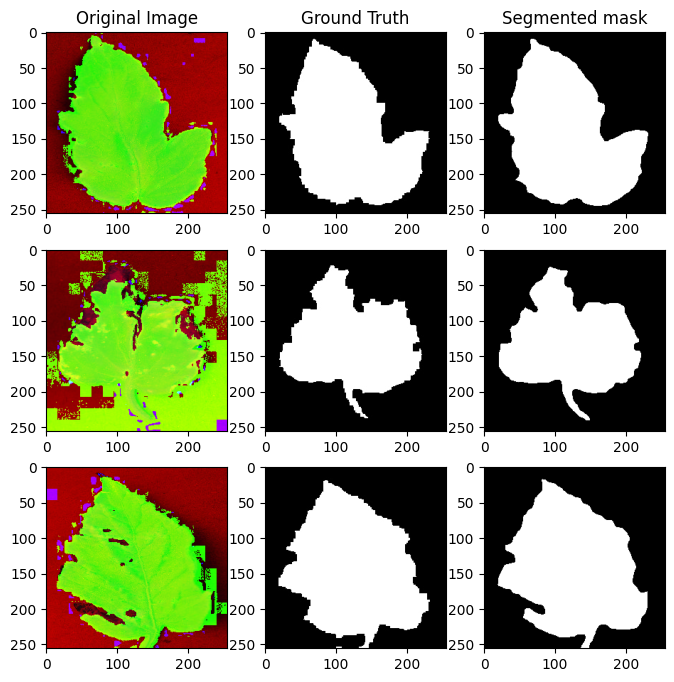

In [23]:
fig = plt.figure(figsize=(8,8))

for i in range(1,3+1):
    # plt.subplot(i+1, 3, 1)
    fig.add_subplot(3,3,(i-1)*2+i)
    plt.imshow(X[i])
    if(i==1):
        plt.title('Original Image')

    # plt.subplot(i+1, 3, 2)
    fig.add_subplot(3,3,(i-1)*2+i+1)
    plt.imshow(Y[i], cmap='gray')
    if(i==1):
        plt.title('Ground Truth')

    # plt.subplot(i+1, 3, 3)
    fig.add_subplot(3,3,(i-1)*2+i+2)
    plt.imshow(res[i],cmap='gray')
    if(i==1):
        plt.title('Segmented mask')

In [24]:
model = tf.keras.models.load_model('tomato_lab_resu2.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef})
res = model.predict(X)

7/7 [==============================] - 9s 1s/step


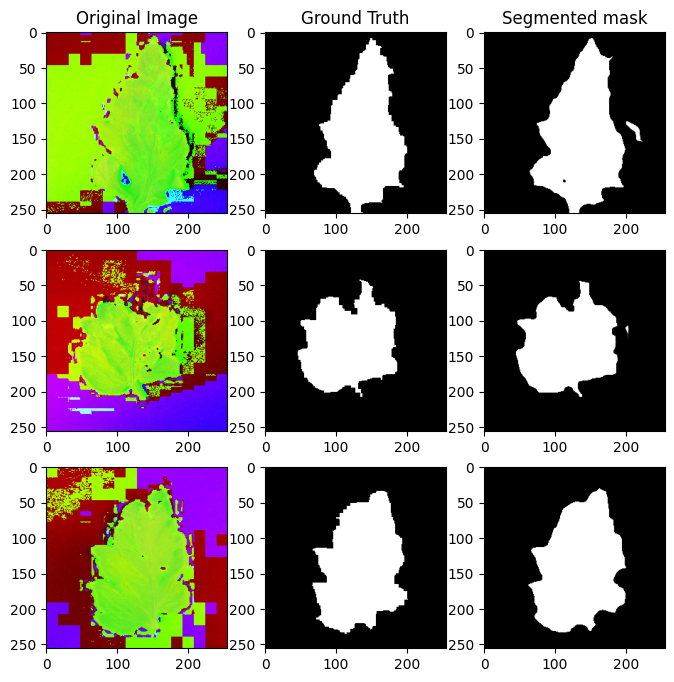

In [27]:
fig = plt.figure(figsize=(8,8))

for i in range(1,3+1):
    # plt.subplot(i+1, 3, 1)
    fig.add_subplot(3,3,(i-1)*2+i)
    plt.imshow(X[i+47])
    if(i==1):
        plt.title('Original Image')

    # plt.subplot(i+1, 3, 2)
    fig.add_subplot(3,3,(i-1)*2+i+1)
    plt.imshow(Y[i+47], cmap='gray')
    if(i==1):
        plt.title('Ground Truth')

    # plt.subplot(i+1, 3, 3)
    fig.add_subplot(3,3,(i-1)*2+i+2)
    plt.imshow(res[i+47],cmap='gray')
    if(i==1):
        plt.title('Segmented mask')

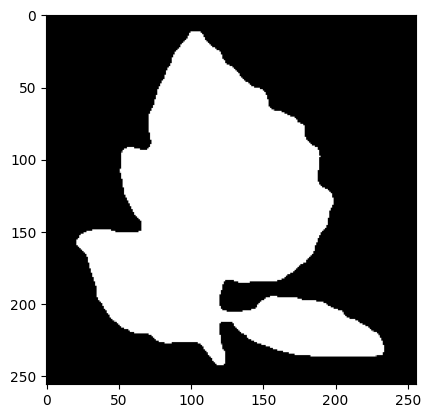

In [25]:
plt.imshow(res[0], cmap='gray')

1/1 [==============================] - 0s 81ms/step


Text(0.5, 1.0, 'Model Result')

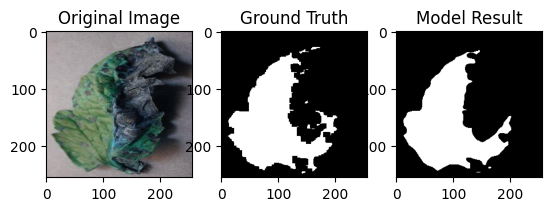

In [33]:
original_image = cv2.imread('tomato/colour/Tomato___Early_blight/0b494c44-8cd0-4491-bdfd-8a354209c3ae___RS_Erly.B 9561.JPG', cv2.IMREAD_COLOR)
# imshow(original_image)
# original_image = resize(original_image, (IMG_HEIGHT, IMG_WIDHT), mode='constant', preserve_range=True)
tes_img = pre_process_imgs(original_image)

# Load your binary mask (replace 'binary_mask.jpg' with your binary mask file)
binary_mask = cv2.imread('tomato/segmented_bw/Tomato___Early_blight/0b494c44-8cd0-4491-bdfd-8a354209c3ae___RS_Erly.B 9561_final_masked.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure that the binary mask is binary (contains only 0 and 255 values)
op = model.predict(tes_img.reshape(1,256,256,3))

# Apply the binary mask to the original image
# segmented_image = cv2.bitwise_and(original_image, original_image, mask=binary_mask)

# Visualize the original image, binary mask, and segmented image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(op.reshape(256,256), cmap='gray')
plt.title('Model Result')

In [24]:
model.evaluate(X,Y)

100/100 [==============================] - 71s 694ms/step - loss: 0.0207 - dice_coef: 0.9791


[0.020738869905471802, 0.9791436791419983]

In [25]:
res = model.predict(X[:200])

7/7 [==============================] - 5s 595ms/step


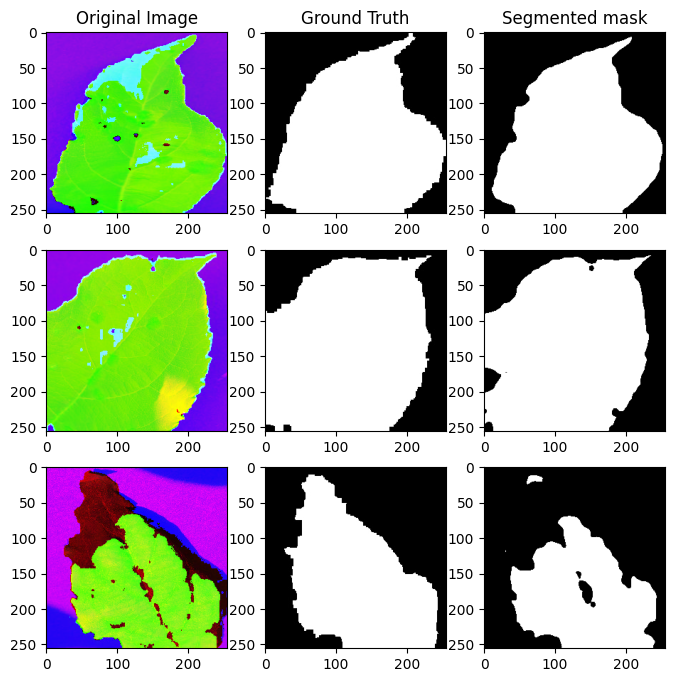

In [29]:
fig = plt.figure(figsize=(8,8))

for i in range(1,3+1):
    # plt.subplot(i+1, 3, 1)
    fig.add_subplot(3,3,(i-1)*2+i)
    plt.imshow(X[i])
    if(i==1):
        plt.title('Original Image')

    # plt.subplot(i+1, 3, 2)
    fig.add_subplot(3,3,(i-1)*2+i+1)
    plt.imshow(Y[i], cmap='gray')
    if(i==1):
        plt.title('Ground Truth')

    # plt.subplot(i+1, 3, 3)
    fig.add_subplot(3,3,(i-1)*2+i+2)
    plt.imshow(res[i],cmap='gray')
    if(i==1):
        plt.title('Segmented mask')

1/1 [==============================] - 0s 60ms/step


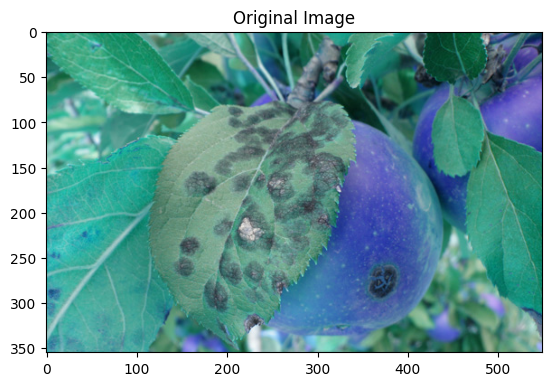

Text(0.5, 1.0, 'Model Result')

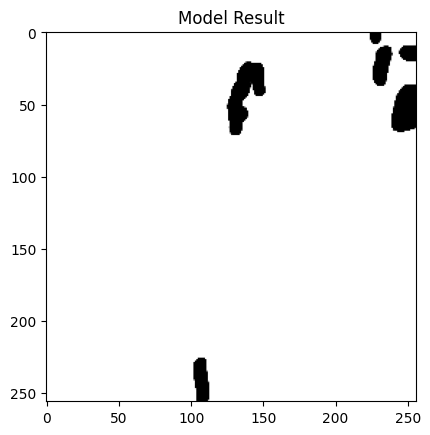

In [28]:
original_image = cv2.imread('01Apple-scab-2-Venturia-inaequalis.ashx_w=600&h=408&bc=ffffff.jpg', cv2.IMREAD_COLOR)
# imshow(original_image)
# original_image = resize(original_image, (IMG_HEIGHT, IMG_WIDHT), mode='constant', preserve_range=True)
tes_img = pre_process_imgs(original_image)

# Load your binary mask (replace 'binary_mask.jpg' with your binary mask file)
# binary_mask = cv2.imread('tomato/segmented_bw/Tomato___Early_blight/0b494c44-8cd0-4491-bdfd-8a354209c3ae___RS_Erly.B 9561_final_masked.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure that the binary mask is binary (contains only 0 and 255 values)
op = model.predict(tes_img.reshape(1,256,256,3))

# Apply the binary mask to the original image
# segmented_image = cv2.bitwise_and(original_image, original_image, mask=binary_mask)

# Visualize the original image, binary mask, and segmented image
# plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.show()

# plt.subplot(1, 3, 2)
# plt.imshow(binary_mask, cmap='gray')
# plt.title('Ground Truth')

# plt.subplot(1, 3, 3)
plt.imshow(op[0], cmap='gray')
plt.title('Model Result')

In [26]:
raw_dir = 'apple/colour/'
seg_dir = 'apple/segmented_bw/'

raw_files_list = get_files_list(raw_dir)
seg_files_list = get_files_list(seg_dir)

X = np.zeros((len(raw_files_list), IMG_HEIGHT, IMG_WIDHT, IMG_CHANNELS), dtype=np.float32)
Y = np.zeros((len(seg_files_list), IMG_HEIGHT, IMG_WIDHT, 1), dtype=np.float32)

In [27]:
for n,id_ in tqdm(enumerate(raw_files_list),total=len(raw_files_list)):
    img = cv2.imread(id_, cv2.IMREAD_COLOR)
    img = pre_process_imgs(img)
    X[n] = img
    
for n,id_ in tqdm(enumerate(seg_files_list),total=len(seg_files_list)):
    img = cv2.imread(id_, cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(cv2.resize(img, (IMG_HEIGHT, IMG_WIDHT)), axis=-1)
    img = img/255.0
    Y[n] = img

100%|██████████| 3171/3171 [00:05<00:00, 617.35it/s] 


In [28]:
model.evaluate(X,Y)

100/100 [==============================] - 133s 1s/step - loss: 0.0525 - dice_coef: 0.9473


[0.05254795774817467, 0.9472711682319641]

In [ ]:
fig = plt.figure(figsize=(8,8))

for i in range(1,3+1):
    # plt.subplot(i+1, 3, 1)
    fig.add_subplot(3,3,(i-1)*2+i)
    plt.imshow(X[i])
    if(i==1):
        plt.title('Original Image')

    # plt.subplot(i+1, 3, 2)
    fig.add_subplot(3,3,(i-1)*2+i+1)
    plt.imshow(Y[i], cmap='gray')
    if(i==1):
        plt.title('Ground Truth')

    # plt.subplot(i+1, 3, 3)
    fig.add_subplot(3,3,(i-1)*2+i+2)
    plt.imshow(res[i],cmap='gray')
    if(i==1):
        plt.title('Segmented mask')